In [3]:
using Pkg
Pkg.activate("..")

 Activating environment at `~/Projects/DPBIC_Quaternions/MLJ/Project.toml`


In [4]:
# Install needed packages (comment if already installed)

Pkg.add("CSV")
Pkg.add("DataFrames")
Pkg.add("MLJ")
Pkg.add("MLJModels")
#Pkg.add("ScikitLearn")
Pkg.add("DecisionTree")
Pkg.add("Random")
Pkg.add("Plots")

  Resolving package versions...
   Updating `~/Projects/DPBIC_Quaternions/MLJ/Project.toml`
 [no changes]
   Updating `~/Projects/DPBIC_Quaternions/MLJ/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/Projects/DPBIC_Quaternions/MLJ/Project.toml`
 [no changes]
   Updating `~/Projects/DPBIC_Quaternions/MLJ/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/Projects/DPBIC_Quaternions/MLJ/Project.toml`
 [no changes]
   Updating `~/Projects/DPBIC_Quaternions/MLJ/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/Projects/DPBIC_Quaternions/MLJ/Project.toml`
 [no changes]
   Updating `~/Projects/DPBIC_Quaternions/MLJ/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/Projects/DPBIC_Quaternions/MLJ/Project.toml`
 [no changes]
   Updating `~/Projects/DPBIC_Quaternions/MLJ/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/Projects/DPBIC_Quaternions/MLJ/Project.toml`
 [n

In [5]:
#Imports and listing present datasets

using CSV
using DataFrames

using MLJ
using Random

using Plots



cd("../dataset")
run(`ls`);

┌ Info: Precompiling MLJ [add582a8-e3ab-11e8-2d5e-e98b27df1bc7]
└ @ Base loading.jl:1260
[ Info: Model metadata loaded from registry. 
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1260


dataset_0_13.csv
dataset_0_16.csv
dataset_13_16.csv


In [6]:
# Load data

ds = readdir()
ds = [i for i in ds if isdir(i)==false]
println(ds)
global dfs = Array{DataFrame}(undef,length(ds))
#global dfs = Dict()

#c = 0
for i in eachindex(ds)
    #c +=1
    df = DataFrame(CSV.File(ds[i]))[:,2:end]
    #df.Coupling_meV = DataFrame(CSV.File(ds[i]))[:,21]
    #df = df[df.Coupling_meV .!= 0, :]
    dfs[i] = df
    #println(size(df))
end

size(dfs[1]),size(dfs[2]),size(dfs[3])

["dataset_0_13.csv", "dataset_0_16.csv", "dataset_13_16.csv"]


((197, 25), (929, 25), (126, 25))

In [7]:
# Reorganize data in the three dataset: old data (article), new 
# and total (concatenation of the two)

df_old = append!(copy(dfs[1]), copy(dfs[3]))
df_new = copy(dfs[2])
df_total = append!(copy(dfs[1]),append!(copy(dfs[2]),copy(dfs[3])))

size(df_old),size(df_new),size(df_total)

((323, 25), (929, 25), (1252, 25))

# Machine Learning - Random Forest

In [10]:
# Parameters setting (used for tests, no longer used)

#rf_model.n_estimators=500
#rf_model.max_depth=100
#rf_model.random_state=1

In [161]:
# Random Forest model loading and training loop definition

rf_model = @load RandomForestRegressor pkg=DecisionTree;
#rf_model.random_state=1

function def_train_eval(df)
    
    c_max = maximum(df.Coupling_meV)
    df.Coupling_meV /= c_max
    
    model = machine(rf_model, select(df, Not(:Coupling_meV)), df.Coupling_meV);
    
    train_index, test_index = partition(eachindex(df.Coupling_meV), 0.7, shuffle=true);
    
    
    
    fit!(model,rows=train_index);
    predictions = predict(model, rows=test_index);
    
    test_df =  df.Coupling_meV[test_index]
    
    some_tests = DataFrame(Preds = predictions[1:5],  True = test_df[1:5], RMS = sqrt.((predictions[1:5] .+ test_df[1:5]).^2))
    #some_tests = test_df[1:5]#predictions[1:5]
    #println(some_tests)
    error = rms(predictions, test_df)^2;
    error, some_tests
end

┌ Info: A model type "RandomForestRegressor" is already loaded. 
│ No new code loaded. 
└ @ MLJModels /home/fabio/.julia/packages/MLJModels/Hrhbw/src/loading.jl:43


def_train_eval (generic function with 1 method)

In [136]:
features_list = ["distance",
                 "q_1_2",  # Useless, just a personal reminder
                 "q_1_2[0]",
                 "q_1_2[1]",
                 "q_1_2[2]",
                 "q_1_2[3]",
                 "q_2_1[0]",
                 "q_2_1[1]",
                 "q_2_1[2]",
                 "q_2_1[3]",
                 "rmsd_id_1_H",
                 "rmsd_id_2_H",
                 "rmsd_id_1",
                 "rmsd_id_2"]#,'rmsd_1_2']

u_one(df) = df[df.Coupling_meV .< 1, :]
u_ten(df) = df[df.Coupling_meV .< 10, :]
o_ten(df) = df[df.Coupling_meV .> 10, :]
full(df) = df

cutters = [u_one, u_ten, o_ten, full]

elements = [[:distance],[:q_1_2],
            [:q0_1_2, :q1_1_2, :q2_1_2, :q3_1_2],
            [:q0_2_1, :q1_2_1, :q2_2_1, :q3_2_1],
            [:rmsd_id_1_H, :rmsd_id_2_H],[:rmsd_id_1, :rmsd_id_2]]

features_comb = [elements[1], 
                 elements[2],
                 vcat(elements[3],elements[4]),
                 vcat(elements[1],elements[2]), 
                 vcat(elements[1],elements[3],elements[4]),
                 vcat(elements[1],elements[2],elements[6]), 
                 vcat(elements[1],elements[2],elements[5]),
                 vcat(elements[1],elements[3],elements[4],elements[6]), 
                 vcat(elements[1],elements[3],elements[4],elements[5]),
                ];


features_comb;

In [189]:
# Define function to loop over the different features and intervals selection

function loop_over_features_and_cuts(df)
    results = DataFrame()
    tests = DataFrame(Preds = [], True = [], RMS = [])
    for features in features_comb
        #println(features)
        temp_results = Float64[]
        #temp_dn = []
        for cut in cutters
            #println("     - ", cut)
            temp_df = copy(df)
            res, temp_tests = def_train_eval(cut(temp_df))
            append!(temp_results, res)
            tests = vcat(tests, temp_tests)
        end
        name = ""
        for i in 1:length(features)
            name = string(name," ",features[i])
        end
        results.col = temp_results
        rename!(results, Dict(:col => name))
    end
    results, tests
end


loop_over_features_and_cuts (generic function with 1 method)

In [190]:
# Train all the models on all the possible combinations of db, features selection and interval
# of coupling 

total, test_total = loop_over_features_and_cuts(df_total)
old, test_old = loop_over_features_and_cuts(df_old)
new, test_new = loop_over_features_and_cuts(df_new);

┌ Info: Training Machine{RandomForestRegressor} @ 1…11.
└ @ MLJBase /home/fabio/.julia/packages/MLJBase/qJs1o/src/machines.jl:182
┌ Info: Training Machine{RandomForestRegressor} @ 1…34.
└ @ MLJBase /home/fabio/.julia/packages/MLJBase/qJs1o/src/machines.jl:182
┌ Info: Training Machine{RandomForestRegressor} @ 6…60.
└ @ MLJBase /home/fabio/.julia/packages/MLJBase/qJs1o/src/machines.jl:182
┌ Info: Training Machine{RandomForestRegressor} @ 3…88.
└ @ MLJBase /home/fabio/.julia/packages/MLJBase/qJs1o/src/machines.jl:182
┌ Info: Training Machine{RandomForestRegressor} @ 8…16.
└ @ MLJBase /home/fabio/.julia/packages/MLJBase/qJs1o/src/machines.jl:182
┌ Info: Training Machine{RandomForestRegressor} @ 8…09.
└ @ MLJBase /home/fabio/.julia/packages/MLJBase/qJs1o/src/machines.jl:182
┌ Info: Training Machine{RandomForestRegressor} @ 1…94.
└ @ MLJBase /home/fabio/.julia/packages/MLJBase/qJs1o/src/machines.jl:182
┌ Info: Training Machine{RandomForestRegressor} @ 9…72.
└ @ MLJBase /home/fabio/.julia/pac

In [194]:
# Save the results obtained in .csv files
# Columns' names are the feature they refer to
# Rows are in this order:
# 1 - Only couples with Coupling under  1 meV
# 2 - Only couples with Coupling under 10 meV
# 3 - Only couples with Coupling over  10 meV
# 1 - All available couples

cd("../results")

CSV.write("total.csv", total)
CSV.write("old.csv", old)
CSV.write("new.csv", new);
CSV.write("test_total.csv", total)
CSV.write("test_old.csv", old)
CSV.write("test_new.csv", new);

println("Saved correctly")

Saved correctly


# The following cells let the user to check the results directly in this notebook without the need to reload the csv files

In [318]:
#showall(total)
show(total, allrows = true, allcols = true)

4×9 DataFrame
│ Row │  distance   │  q_1_2      │
│     │ Float64     │ Float64     │
├─────┼─────────────┼─────────────┤
│ 1   │ 0.0196386   │ 0.0354231   │
│ 2   │ 0.0118764   │ 0.0108736   │
│ 3   │ 0.00105326  │ 0.00113901  │
│ 4   │ 0.000573318 │ 0.000733715 │

│ Row │  q0_1_2 q1_1_2 q2_1_2 q3_1_2 q0_2_1 q1_2_1 q2_2_1 q3_2_1 │
│     │ Float64                                                  │
├─────┼──────────────────────────────────────────────────────────┤
│ 1   │ 0.0386234                                                │
│ 2   │ 0.00915489                                               │
│ 3   │ 0.000919669                                              │
│ 4   │ 0.000630877                                              │

│ Row │  distance q_1_2 │
│     │ Float64         │
├─────┼─────────────────┤
│ 1   │ 0.026158        │
│ 2   │ 0.00743151      │
│ 3   │ 0.00105567      │
│ 4   │ 0.000842161     │

│ Row │  distance q0_1_2 q1_1_2 q2_1_2 q3_1_2 q0_2_1 q1_2_1 q2_2_1 q3_2_1 │
│   

In [11]:
show(old, allrows = true, allcols = true)

4×9 DataFrame
│ Row │  distance  │  q         │  q[0] q[1] q[2] q[3] │  distance q │
│     │ Float64    │ Float64    │ Float64              │ Float64     │
├─────┼────────────┼────────────┼──────────────────────┼─────────────┤
│ 1   │ 0.0676779  │ 0.037929   │ 0.0372089            │ 0.0823526   │
│ 2   │ 0.00301404 │ 0.00297164 │ 0.00248173           │ 0.0179053   │
│ 3   │ 0.00217514 │ 0.00176408 │ 0.00192745           │ 0.00156941  │
│ 4   │ 0.0015015  │ 0.00146993 │ 0.00117307           │ 0.00159895  │

│ Row │  distance q[0] q[1] q[2] q[3] │  distance q rmsd_id_1 rmsd_id_2 │
│     │ Float64                       │ Float64                         │
├─────┼───────────────────────────────┼─────────────────────────────────┤
│ 1   │ 0.0656262                     │ 0.0605658                       │
│ 2   │ 0.00345333                    │ 0.00412106                      │
│ 3   │ 0.00165186                    │ 0.00159386                      │
│ 4   │ 0.00126009                    │ 0.00

In [12]:
show(new, allrows = true, allcols = true)

4×9 DataFrame
│ Row │  distance  │  q          │  q[0] q[1] q[2] q[3] │  distance q │
│     │ Float64    │ Float64     │ Float64              │ Float64     │
├─────┼────────────┼─────────────┼──────────────────────┼─────────────┤
│ 1   │ 0.0262628  │ 0.0272934   │ 0.0255938            │ 0.0371001   │
│ 2   │ 0.0095535  │ 0.00910684  │ 0.0117332            │ 0.0085141   │
│ 3   │ 0.00140834 │ 0.00158654  │ 0.00164431           │ 0.00158221  │
│ 4   │ 0.0010519  │ 0.000592446 │ 0.00068934           │ 0.000939983 │

│ Row │  distance q[0] q[1] q[2] q[3] │  distance q rmsd_id_1 rmsd_id_2 │
│     │ Float64                       │ Float64                         │
├─────┼───────────────────────────────┼─────────────────────────────────┤
│ 1   │ 0.0352568                     │ 0.0310282                       │
│ 2   │ 0.0123184                     │ 0.0105505                       │
│ 3   │ 0.0013763                     │ 0.00195234                      │
│ 4   │ 0.000720479                  

In [121]:
# Train a Random Forest Regressor with df_in, then create a plot using df_test, with distances 
# on the x and predictions on the y
# If save is true, the graph will be saved; if save is false, it will be displayed

function def_train_graph(df_in, df_test, fig_name="", save=false)#, features)
    c_max = maximum(df_in.Coupling_meV)
    df_in.Coupling_meV /= c_max
    
    model = machine(rf_model, select(df_in, Not(:Coupling_meV)), df_in.Coupling_meV);
    
    train_index = [i for i=1:length(df_in.q)]
    test_index = [i for i=1:length(df_test.q)]
    
    fit!(model)
    
    pred_coupling = model(df_test)#*c_max
    y = reshape([(pred_coupling) ; log.(pred_coupling)], length(pred_coupling),2)
    
    if save
        plot(df_test.distance, y, label=["prediction" "log(prediction)"])
        savefig(fig_name*".png")
    else
        plot(df_test.distance, y, label=["prediction" "log(prediction)"])
    end
    
end

def_train_graph (generic function with 3 methods)

In [122]:
cd("../figures")

# Create dummy distances and q (orientation)
distance = [i for i=9:0.1:17];
q = [1 for i=9:0.1:17];
#q = [0.9341968913648596 for i=9:0.1:17]

In [123]:
# Create a dummy df_test with fixed distances for each couple and variable q (orientation)

df_test = DataFrame()
df_test.distance = distance
df_test.q = q

# Recreate df_total because I don't know if previous model modified it 
df_total = append!(copy(dfs[1]),append!(copy(dfs[2]),copy(dfs[3]))) 
#Then select only the features needed for the verification
df_endev = select(df_total, :distance, :q, :Coupling_meV)

#df_test
def_train_graph(df_endev, df_test, "total", true)

┌ Info: Training Machine{RandomForestRegressor} @ 1…92.
└ @ MLJBase /home/fabio/.julia/packages/MLJBase/qJs1o/src/machines.jl:182


In [124]:
# Same as before with df_old instead of df_total

df_test = DataFrame()
df_test.distance = distance
df_test.q = q

df_old = append!(copy(dfs[1]), copy(dfs[3]))

df_endev = select(df_old, :distance, :q, :Coupling_meV)

def_train_graph(df_endev, df_test, "old", true)

┌ Info: Training Machine{RandomForestRegressor} @ 1…04.
└ @ MLJBase /home/fabio/.julia/packages/MLJBase/qJs1o/src/machines.jl:182


In [125]:
# Same as before with df_new instead of df_total

df_test = DataFrame()
df_test.distance = distance
df_test.q = q

df_new = copy(dfs[2])

df_endev = select(df_new, :distance, :q, :Coupling_meV)

def_train_graph(df_endev, df_test, "new", true)#, vcat(elements[1],elements[2]))

┌ Info: Training Machine{RandomForestRegressor} @ 9…03.
└ @ MLJBase /home/fabio/.julia/packages/MLJBase/qJs1o/src/machines.jl:182


In [145]:
function def_train_hist(df, features)
    
    #println("blablabla")
    c_max = maximum(df.Coupling_meV)
    df.Coupling_meV /= c_max
    #println("blablabla")
    model = machine(rf_model, select(df, Not(:Coupling_meV)), df.Coupling_meV);
    #println("blablabla")
    train_index, test_index = partition(eachindex(df.Coupling_meV), 0.7, shuffle=true);
    #println("blablabla")
    #train = df[train_index, :]
    #test = df[test_index, :]
    
    #model = RandomForestRegressor(n_estimators=500, max_depth=100, random_state=1)
    fit!(model,rows=train_index);
    #println("blablabla")
    predictions = predict(model, rows=test_index);
    #println("blablabla")
    #error = rms(predictions, df.Coupling_meV[test_index])^2;
    #error
    
    histogram([df[train_index, :Coupling_meV], df[test_index, :Coupling_meV], predictions], label=["train" "test" "predictions"])
    
end

def_train_hist (generic function with 1 method)

┌ Info: Training Machine{RandomForestRegressor} @ 1…70.
└ @ MLJBase /home/fabio/.julia/packages/MLJBase/qJs1o/src/machines.jl:182


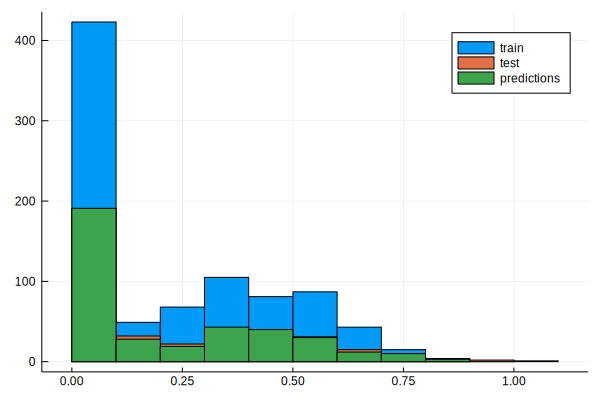

In [175]:
feats = features_list = ["distance", "q"]
def_train_hist(df_total, feats)

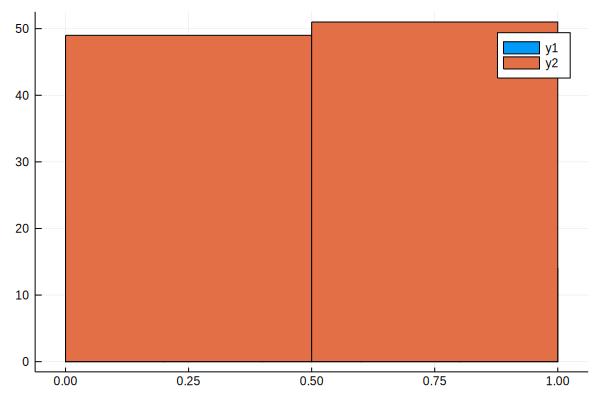

In [148]:
x = rand(100)
y = rand(100)

histogram([x y])

In [149]:
train_index, test_index = partition(eachindex(df_total.Coupling_meV), 0.7, shuffle=true)

df_total[train_index, :]

876×20 DataFrame. Omitted printing of 14 columns
│ Row │ #MolI │ MolJ  │ distance │ q        │ q[0]       │ q[1]      │
│     │ Int64 │ Int64 │ Float64  │ Float64  │ Float64    │ Float64   │
├─────┼───────┼───────┼──────────┼──────────┼────────────┼───────────┤
│ 1   │ 5     │ 180   │ 11.1024  │ 3.0937   │ -0.138891  │ 0.956365  │
│ 2   │ 93    │ 135   │ 12.6941  │ 0.560663 │ 0.861155   │ -0.243249 │
│ 3   │ 71    │ 172   │ 14.56    │ 3.05194  │ -0.240123  │ 0.0726801 │
│ 4   │ 169   │ 178   │ 13.2687  │ 2.90271  │ -0.16639   │ 0.479776  │
│ 5   │ 108   │ 192   │ 14.3998  │ 2.9033   │ -0.0155765 │ 0.137824  │
│ 6   │ 125   │ 173   │ 14.1274  │ 2.22294  │ -0.4592    │ -0.348364 │
│ 7   │ 52    │ 79    │ 16.1902  │ 2.38702  │ 0.730542   │ 0.659666  │
│ 8   │ 50    │ 131   │ 9.38557  │ 1.47097  │ 0.701021   │ 0.499274  │
│ 9   │ 178   │ 190   │ 16.3639  │ 2.79307  │ 0.170841   │ -0.889315 │
│ 10  │ 67    │ 195   │ 11.7072  │ 0.48605  │ 0.419879   │ 0.169603  │
⋮
│ 866 │ 106   │ 153   │ 10.6377  │ 2.55101  │ 0.347325   │ -0.419611 │
│ 867 │ 78    │ 196   │ 15.734   │ 2.46976  │ 0.77806    │ -0.574478 │
│ 868 │ 80    │ 118   │ 12.1039  │ 2.3268   │ -0.278608  │ 0.339923  │
│ 869 │ 2     │ 138   │ 16.4351  │ 2.49756  │ 0.742691   │ 0.0944877 │
│ 870 │ 164   │ 193   │ 14.2725  │ 2.72286  │ -0.108567  │ 0.0604303 │
│ 871 │ 55    │ 140   │ 10.767   │ 2.79074  │ -0.891728  │ 0.262024  │
│ 872 │ 106   │ 126   │ 12.6985  │ 1.75461  │ 0.776322   │ -0.104216 │
│ 873 │ 34    │ 163   │ 13.4018  │ 2.45217  │ -0.649123  │ 0.518367  │
│ 874 │ 41    │ 79    │ 10.7509  │ 2.01028  │ 0.79091    │ -0.505846 │
│ 875 │ 113   │ 199   │ 14.8151  │ 1.73225  │ 0.872552   │ 0.453701  │
│ 876 │ 53    │ 199   │ 10.5276  │ 1.72322  │ 0.374396   │ 0.325686  │

In [295]:
df_total.Coupling_meV

1252-element Array{Float64,1}:
 -0.021436276456
 -0.028593181398
 -0.031077160269
 -0.028242983481
 -0.024768424009
 -0.018898965583
 -0.031550327495
 -0.031687556357999996
 -0.059978371639
 -0.035560236465
 -0.027942569868999997
 -0.055711484111
 -0.036034123306
  ⋮
 -0.067646999737
 -0.037672917026
 -0.032367791751
 -0.09227184535
 -0.036118762829
 -0.031451325103
 -0.044854344469999995
 -0.035774661266
 -0.08850419694299999
 -0.034825817264
 -0.079024347543
 -0.085459735902

In [173]:
size(df_total),size(df_old)

((1252, 25), (323, 25))

In [176]:
vcat(df_total, df_old)

1575×25 DataFrame. Omitted printing of 19 columns
│ Row  │ MolI  │ MolJ  │ distance │ q_1_2    │ q_2_1    │ q0_1_2     │
│      │ Int64 │ Int64 │ Float64  │ Float64  │ Float64  │ Float64    │
├──────┼───────┼───────┼──────────┼──────────┼──────────┼────────────┤
│ 1    │ 12    │ 67    │ 10.6108  │ 1.44307  │ 1.44307  │ -0.259854  │
│ 2    │ 2     │ 136   │ 11.9356  │ 1.35629  │ 1.35629  │ 0.857047   │
│ 3    │ 55    │ 185   │ 11.7913  │ 2.02358  │ 2.02358  │ -0.504684  │
│ 4    │ 6     │ 47    │ 10.7874  │ 2.10092  │ 2.10092  │ -0.2135    │
│ 5    │ 83    │ 123   │ 10.9149  │ 2.00939  │ 2.00939  │ 0.302776   │
│ 6    │ 92    │ 129   │ 11.0348  │ 0.945241 │ 0.945241 │ -0.380844  │
│ 7    │ 126   │ 134   │ 10.7902  │ 2.92612  │ 2.92612  │ 0.676201   │
│ 8    │ 46    │ 77    │ 10.7235  │ 3.04634  │ 3.04634  │ 0.115082   │
│ 9    │ 43    │ 49    │ 10.4857  │ 0.731824 │ 0.731824 │ 0.799728   │
│ 10   │ 178   │ 181   │ 12.0757  │ 3.12769  │ 3.12769  │ 0.00350934 │
⋮
│ 1565 │ 86    │ 87    │ 13.3022  │ 1.6353   │ 1.6353   │ 0.666723   │
│ 1566 │ 54    │ 112   │ 12.4844  │ 1.98613  │ 1.98613  │ -0.681345  │
│ 1567 │ 105   │ 111   │ 15.3118  │ 1.50252  │ 1.50252  │ 0.896898   │
│ 1568 │ 68    │ 73    │ 13.0819  │ 3.11477  │ 3.11477  │ 0.497052   │
│ 1569 │ 23    │ 79    │ 12.3259  │ 1.65549  │ 1.65549  │ -0.0580537 │
│ 1570 │ 83    │ 136   │ 13.2664  │ 2.94236  │ 2.94236  │ 0.705883   │
│ 1571 │ 28    │ 165   │ 14.2427  │ 2.81815  │ 2.81815  │ -0.399019  │
│ 1572 │ 22    │ 51    │ 15.464   │ 2.52495  │ 2.52495  │ 0.267859   │
│ 1573 │ 30    │ 38    │ 11.9995  │ 2.62985  │ 2.62985  │ 0.254568   │
│ 1574 │ 2     │ 138   │ 16.4351  │ 2.49756  │ 2.49756  │ 0.742691   │
│ 1575 │ 182   │ 184   │ 15.1116  │ 2.83806  │ 2.83806  │ -0.626024  │